In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from datasets import load_dataset
from PIL import Image
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import datasets, transforms
from transformers import AutoModelForCausalLM, AutoTokenizer, AdamW
from vit_pytorch import ViT
from vit_pytorch.vit import Attention, repeat, Transformer, FeedForward, pair, Rearrange
# from einops import rearrange
# from mambapy.mamba import Mamba, MambaConfig
from zeta.nn import SSM


d:\Pas\UofT\ECE1512\ProjectB\mamba\myenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
class MambaEncoderBlock(nn.Module):
    def __init__(self, dim: int, dt_rank: int, dim_inner: int, d_state: int):
        super().__init__()
        self.dim = dim
        self.dt_rank = dt_rank
        self.dim_inner = dim_inner
        self.d_state = d_state
        self.conv = nn.Conv1d(in_channels=dim, out_channels=dim, kernel_size=1)

        self.norm = nn.LayerNorm(dim)
        self.silu = nn.SiLU()
        self.ssm = SSM(dim, dt_rank, dim_inner, d_state)

        # Linear layer for z and x
        self.proj_x = nn.Linear(dim, dim)
        self.proj_z = nn.Linear(dim, dim)
        self.proj_out = nn.Linear(dim, dim)

        # Softplus
        self.softplus = nn.Softplus()

    def forward(self, x: torch.Tensor):
        x = self.norm(x)

        z = self.proj_z(x)
        x = self.proj_x(x)

        x = self.conv(x.permute(0, 2, 1))
        x = x.permute(0, 2, 1)
        x = self.ssm(x)

        return self.proj_out(x*z)

In [4]:
class VisMamba(ViT):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, dt_rank, dim_inner, pool = 'cls', channels = 3, d_state = 64, dropout = 0., emb_dropout = 0.):
        super().__init__(image_size=image_size, patch_size=patch_size, num_classes=num_classes, dim=dim, depth=depth, heads=dt_rank, mlp_dim=dim_inner, pool=pool, channels=channels, dim_head=d_state, dropout=dropout, emb_dropout=emb_dropout)
        del self.transformer
        self.mamba_encoder = nn.Sequential(
            *[MambaEncoderBlock(dim, dt_rank, dim, d_state)]
        )

    def forward(self, img):
        x = self.to_patch_embedding(img)
        b, n, _ = x.shape

        cls_tokens = repeat(self.cls_token, '1 1 d -> b 1 d', b = b)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, :(n + 1)]
        x = self.dropout(x)
        x = self.mamba_encoder(x)
        # return x
        return x.view(x.size(0), -1)
        print(x.shape)
        x = x.mean(dim = 1) if self.pool == 'mean' else x[:, 0]

        x = self.to_latent(x)
        return x

In [5]:
class CapMamba(nn.Module):
    def __init__(self, model_dim=768, max_length=50, image_size=256, patch_size=32, dim=128,):
        super(CapMamba, self).__init__()
        self.encoder = VisMamba(
            image_size=image_size,
            patch_size=patch_size,
            num_classes=10,
            dim=dim,
            depth=4,
            dt_rank=8,
            dim_inner=128,
            pool='mean',
            channels=3,
            d_state=64,
        )
        image_dim = int((image_size/patch_size)**2+1) * dim
        # image_dim = dim
        self.fc = nn.Linear(image_dim, model_dim)
        self.lm = AutoModelForCausalLM.from_pretrained("gpt2")
        self.tokenizer = AutoTokenizer.from_pretrained("gpt2")

        pad_token = '<[PAD]>'
        bos_token = '<[BOS]>'
        self.tokenizer.add_special_tokens({'pad_token': pad_token, 'bos_token': bos_token})

        # Set pad and eos tokens explicitly
        self.tokenizer.pad_token = pad_token

        # Convert them to IDs
        self.tokenizer.pad_token_id = self.tokenizer.convert_tokens_to_ids(self.tokenizer.pad_token)
        self.lm.resize_token_embeddings(len(self.tokenizer))
        self.transformer = self.lm.transformer
        self.max_length = max_length

    def image_encoder(self, img):
        img_emb = self.encoder(img)
        img_emb = self.fc(img_emb)
        return img_emb

    def forward(self, **kwargs):
        return self.lm(**kwargs)


    def decode(self, tokens):
        def truncate_at_stop(tokens):
            truncated = []
            for token in tokens:
                if token == self.tokenizer.eos_token_id or token == self.tokenizer.pad_token_id:
                    break
                truncated.append(token)
            return truncated

        if isinstance(tokens, torch.Tensor) and tokens.dim() == 1:
            # Truncate and decode single sequence
            truncated_tokens = truncate_at_stop(tokens.tolist())
            return self.tokenizer.decode(truncated_tokens, skip_special_tokens=False)
        else:
            # Truncate and decode batch of sequences
            outputs = []
            for token_sequence in tokens:
                truncated_tokens = truncate_at_stop(token_sequence.tolist())
                outputs.append(self.tokenizer.decode(truncated_tokens, skip_special_tokens=False))
            return outputs

In [6]:
class ImageCaptionDataset(Dataset):
    def __init__(self, dataset, model, name, datatype="train"):
        self.dataset = dataset
        self.tokenizer = model.tokenizer
        self.max_length = model.max_length
        self.transform = transforms.Compose([
            transforms.Lambda(lambda img: img.convert('RGB') if img.mode != 'RGB' else img),
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        self.name = name
        self.datatype = datatype

    def __len__(self):
        return len(self.dataset[self.datatype])

    def __getitem__(self, idx):
        # Load image
        if self.name=="Food":
            image = self.dataset['train'][idx]['image']
        elif self.name=="COCO":
            image = self.dataset['val'][idx]['image']
        image = self.transform(image)

        if self.name=="Food":
            caption = self.dataset['train'][idx]['text']
            if caption.startswith('s/'):
                caption = caption[2:]
        elif self.name=="COCO":
            captions = self.dataset['val'][idx]['answer']
            caption = np.random.choice(captions)
        caption = self.tokenizer.bos_token + caption + self.tokenizer.eos_token
        caption_tokens = self.tokenizer(caption, truncation=True, padding='max_length', max_length=self.max_length, return_tensors="pt")

        return image, caption_tokens['input_ids'].squeeze(), caption_tokens['attention_mask'].squeeze()


In [7]:
model = CapMamba(max_length=50).to(device)

In [8]:
dataset = load_dataset("zmao/chinese_food_caption", cache_dir='dataset')
FoodDataset = ImageCaptionDataset(dataset, model, "Food", "train")

In [ ]:
# dataset = load_dataset("lmms-lab/COCO-Caption2017", cache_dir='dataset')
# CocoDataset = ImageCaptionDataset(dataset, model, "COCO", "val")
# del dataset

In [10]:
def get_dataloader(dataset, batch_size=16, test_size=0.05):
    np.random.seed(0)
    # Split the dataset into train and test (5% for testing)
    train_indices, test_indices = train_test_split(range(len(dataset)), test_size=test_size, random_state=42)

    # Create subsets for train and test datasets
    train_subset = Subset(dataset, train_indices)
    test_subset = Subset(dataset, test_indices)

    # Create dataloaders for both train and test
    train_dataloader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)
    return train_dataloader, test_dataloader
food_train_dataloader, food_test_dataloader = get_dataloader(FoodDataset, batch_size=16)
# coco_train_dataloader, coco_test_dataloader = get_dataloader(CocoDataset, batch_size=32)


In [11]:
def count_parameters(model):
    for name, module in model.named_children():
        # Count the parameters of each module
        total_params = sum(p.numel() for p in module.parameters())
        print(f"{name}: {total_params} parameters")

# Example usage
count_parameters(model)

encoder: 502666 parameters
fc: 6390528 parameters
lm: 124441344 parameters
transformer: 124441344 parameters


In [12]:
def train(model, train_dataloader, optimizer):
    model.train()
    total_loss = 0.0

    #attention_mask
    for images, labels, _ in train_dataloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        img_emb = model.image_encoder(images)
        if img_emb.dim()==2:
            img_emb = img_emb.unsqueeze(1)
        labels_emb = model.transformer.wte(labels[:, :-1])
        embs = torch.cat([img_emb, labels_emb], dim=1)
        outputs = model(inputs_embeds=embs)
        logits = outputs.logits[:, img_emb.size(1)-1:, :]
        targets = labels[:, 1:].contiguous().view(-1)

        loss = F.cross_entropy(
            logits[:, :-1, :].contiguous().view(-1, logits.size(-1)),
            targets,
            ignore_index=model.tokenizer.pad_token_id
        )

        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_dataloader)
    return avg_loss

In [13]:
# Initialize optimizer once, before the training loop
optimizer = AdamW(model.parameters(), lr=1e-5, weight_decay=0.01)
losses = []

In [14]:
# Training loop for multiple epochs
num_epochs = 1000
for epoch in range(num_epochs):  # Loop through 300 epochs
    loss = train(model, food_train_dataloader, optimizer)
    losses.append(loss) 
    print(f"Epoch [{epoch + 1}/{num_epochs}] - Average Training Loss: {loss:.4f}") 

Epoch [1/1000] - Average Training Loss: 27.6291
Epoch [2/1000] - Average Training Loss: 8.7572
Epoch [3/1000] - Average Training Loss: 7.6069
Epoch [4/1000] - Average Training Loss: 6.9914
Epoch [5/1000] - Average Training Loss: 6.5780
Epoch [6/1000] - Average Training Loss: 6.2562
Epoch [7/1000] - Average Training Loss: 6.0183
Epoch [8/1000] - Average Training Loss: 5.8751
Epoch [9/1000] - Average Training Loss: 5.6915
Epoch [10/1000] - Average Training Loss: 5.6864
Epoch [11/1000] - Average Training Loss: 5.5104
Epoch [12/1000] - Average Training Loss: 5.4240
Epoch [13/1000] - Average Training Loss: 5.3320
Epoch [14/1000] - Average Training Loss: 5.2546
Epoch [15/1000] - Average Training Loss: 5.1980
Epoch [16/1000] - Average Training Loss: 5.1701
Epoch [17/1000] - Average Training Loss: 5.1111
Epoch [18/1000] - Average Training Loss: 5.0683
Epoch [19/1000] - Average Training Loss: 5.0277
Epoch [20/1000] - Average Training Loss: 5.0213
Epoch [21/1000] - Average Training Loss: 4.9717


In [15]:
torch.save(model, 'food_model.pt')

In [16]:
torch.save(torch.tensor(losses), 'food_loss.pt')

In [17]:
def generate_caption(model, images, max_length=50):
    model.eval()
    with torch.no_grad():
        images = images.to(device)
        img_emb = model.image_encoder(images)
        # Ensure embeddings are properly shaped
        if img_emb.dim() == 2:
            img_emb = img_emb.unsqueeze(1)
        generated_tokens = torch.full((images.size(0), 1), model.tokenizer.bos_token_id, dtype=torch.long).to(device)
        # generated_tokens = torch.empty((images.size(0), 1), dtype=torch.long).to(device)

        for _ in range(max_length):
            # Prepare input embeddings
            input_ids = torch.tensor(generated_tokens, device=device)  # Shape: (1, seq_len)
            input_embs = model.transformer.wte(input_ids)
            embs = torch.cat([img_emb, input_embs], dim=1)

            # Forward pass through the model
            outputs = model(inputs_embeds=embs)
            logits = outputs.logits  # Shape: (1, seq_len, vocab_size)

            next_tokens = torch.argmax(logits[:, -1, :], dim=-1)
            generated_tokens = torch.cat([generated_tokens, next_tokens.unsqueeze(1)], dim=1)

            # Stop generation if <EOS> token is generated for any sequence in the batch
            eos_mask = next_tokens == model.tokenizer.eos_token_id
            if eos_mask.all():
                    break

            # Decode generated tokens into text
        # captions = []/
        # for tokens in generated_tokens:
        tk = [tokens.tolist() for tokens in generated_tokens]
        tk = [tokens[:tokens.index(model.tokenizer.eos_token_id)] if model.tokenizer.eos_token_id in tokens else tokens for tokens in tk]

        captions = [model.tokenizer.decode(tokens, skip_special_tokens=True) for tokens in tk]
        captions = [sent.strip() for sent in captions]

        return captions

In [20]:
def eval_text(dataloader, model, num_print=5):
    count = 0
    for imgs, labels, _ in dataloader:
        captions = generate_caption(model, imgs)
        reference_captions = [model.tokenizer.decode(label[1:], skip_special_tokens=True) for label in labels]
        for img, ref, cap in zip(imgs, reference_captions, captions):
            # Plot the image
            plt.figure(figsize=(2, 2))
            plt.imshow(img.permute(1, 2, 0).cpu())
            plt.axis('off')  # Hide axes
            plt.show()
            count+=1
            print("Ref :", ref)
            print("Pred:", cap)
            if count >= num_print: return

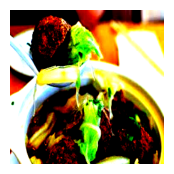

Ref : lions head
Pred: ions


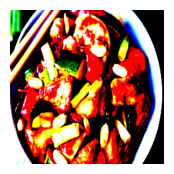

Ref : stirfried chinese broccoli with crispy pork belly khana mu krop
Pred: ir ch broccoli crispy bellyana koch chariu


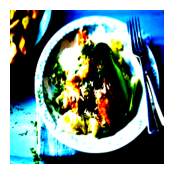

Ref : quick orange and lemon chicken
Pred: orange lemon lemon lemon


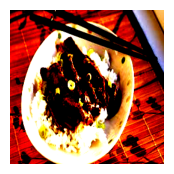

Ref : five spice beef
Pred: spice


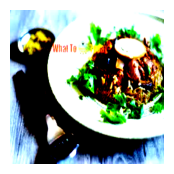

Ref : steamed rice with chicken  nasi tim ayam
Pred: amed with and rice chicken n timam


In [21]:
eval_text(food_train_dataloader, model)

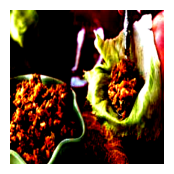

Ref : crispy gingerandgarlic asian turkey lettuce wraps
Pred: inese chickeners broccoli


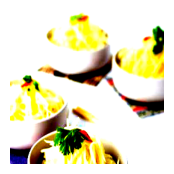

Ref : chinese style potato salad
Pred: inese dpling


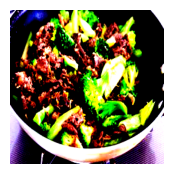

Ref : broccoli beef
Pred: ame with noodles chili


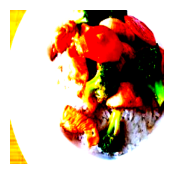

Ref : chinese hoisin chicken
Pred: ineseamed balls chicken cast dish


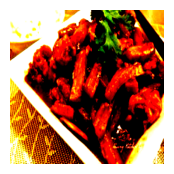

Ref : malaysian style braised chicken with bitter gourd
Pred: po chicken


In [22]:
eval_text(food_test_dataloader, model)

In [23]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
def eval_bleu(dataloader, model, num_eval=int(1e6)):
    # Initialize smoothing function for BLEU
    smoothie = SmoothingFunction().method4

    # Function to evaluate a single caption
    def evaluate_caption(predicted, reference):
        # Reference needs to be a list of lists for BLEU
        reference = [reference.split()]
        predicted = predicted.split()
        weights = [(1, ), (0.25, 0.25, 0.25, 0.25)]
        bleu_score = [sentence_bleu(reference, predicted, weights=w, smoothing_function=smoothie) for w in weights]
        return bleu_score

    bleu_scores = []
    eval_count = 0
    for imgs, labels, _ in dataloader:
        captions = generate_caption(model, imgs)
        reference_captions = [model.tokenizer.decode(label[1:], skip_special_tokens=True) for label in labels]

        bleu_scores.append([evaluate_caption(caption, ref) for caption, ref in zip(captions, reference_captions)])
        eval_count += len(bleu_scores[-1])
        if eval_count >= num_eval: break
    bleu_scores = np.vstack(bleu_scores)[:num_eval]
    avg_bleu = bleu_scores.mean(axis=0)
    print(f"Average BLEU Score: {[round(e, 4) for e in avg_bleu]}")
    return bleu_scores
bleu_scores = eval_bleu(food_train_dataloader, model)
bleu_scores = eval_bleu(food_test_dataloader, model)

Average BLEU Score: [0.1962, 0.0306]
Average BLEU Score: [0.0431, 0.0091]


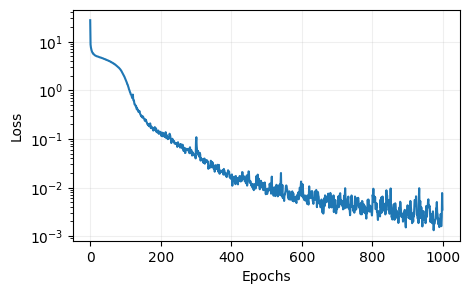

In [32]:
plt.figure(figsize=(5, 3))
plt.plot(losses)
plt.yscale('log')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.xlabel('Epochs')
plt.grid(alpha=0.2)
plt.show()

In [33]:
model_coco = torch.load("coco_model_360.pt")

In [34]:
dataset = load_dataset("lmms-lab/COCO-Caption2017", cache_dir='dataset')
CocoDataset = ImageCaptionDataset(dataset, model, "COCO", "val")
coco_train_dataloader, coco_test_dataloader = get_dataloader(CocoDataset, batch_size=32)
del dataset

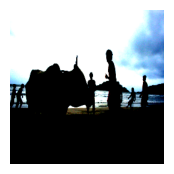

Ref : Young men playing on the beach with a cow in the foreground.
Pred: bull running a on grass hill to boys


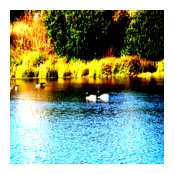

Ref : A family of swans swimming on top of a lake.
Pred: cks a ofese in body water trees


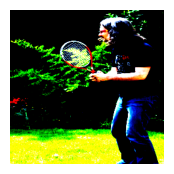

Ref : A man in a defensive stance holding a racquet.
Pred: old black with rack standing grass two in of


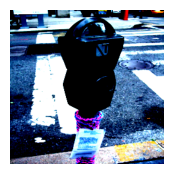

Ref : A knit cover and note hang below a parking meter. 
Pred: parking with note attached it


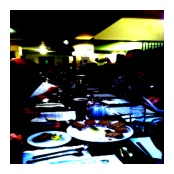

Ref : A long table full of people on both sides.
Pred: long table of full people both on


In [35]:
eval_text(coco_train_dataloader, model_coco)

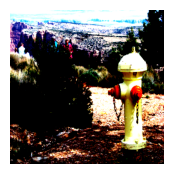

Ref : A fire hydrant near a hiking trail outside.
Pred: brown standing top a covered grass field


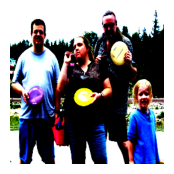

Ref : A group of people each holding a frisbee
Pred: woman black white brown standing to brown near fire


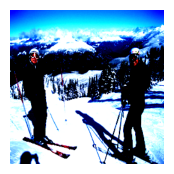

Ref : Two people in ski gear standing at the top of a mountain.
Pred: people a and donkey through water buildings


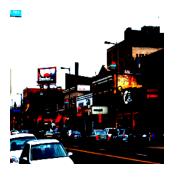

Ref : A variety of cars on a street with buildings.
Pred: horse on back people on withpacks  luggage the was a of


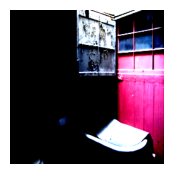

Ref : An old and run down bathroom with dark red accent colors.
Pred: black white red black white yellow pink purple gray yellow yellow pink yellow pink yellow pink yellow pink yellow pink yellow pink yellow pink yellow pink yellow pink yellow pink yellow pink yellow pink yellow pink yellow pink yellow pink yellow pink yellow pink yellow pink yellow pink yellow pink


In [36]:
eval_text(coco_test_dataloader, model_coco)

In [53]:
bleu_scores = eval_bleu(coco_train_dataloader, model_coco)
bleu_scores = eval_bleu(coco_test_dataloader, model_coco)

Average BLEU Score: [0.2316, 0.0261]
Average BLEU Score: [0.098, 0.0152]


Note: There was an error during the first 200 epochs of training, resulting in the loss of loss tracking. However, the plot is still available, so the plots are separated.

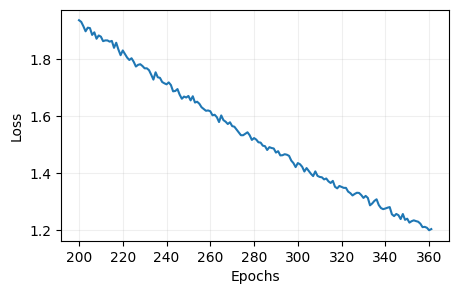

In [52]:
l2 = torch.load('coco_loss_160.pt')
plt.figure(figsize=(5, 3))
plt.plot(range(200, 200+len(l2)), l2)
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.xlabel('Epochs')
plt.grid(alpha=0.2)
plt.show()